# Cora 데이터
- 노드 분류(node classification) 문제를 해결하기 위한 표준 벤치마크로 자주 활용


## 데이터셋 설명
- 노드 (Nodes): 학술 논문을 나타냄.
- 엣지 (Edges): 논문 간의 인용 관계를 나타냄. (무방향 그래프)
- 노드 특징 (Node Features): 각 논문의 Bag-of-Words 표현으로, 논문에 사용된 단어들의 빈도를 나타냄.
- 클래스 (Classes): 각 노드는 하나의 주제(class)에 속함.

## Cora 데이터셋의 사용 목적
- 노드 분류 (Node Classification):

각 논문이 어떤 주제에 속하는지 분류하는 문제.
학습: 일부 노드에 대해 레이블을 제공하고 나머지 노드의 레이블을 예측.

- 링크 예측 (Link Prediction):

두 논문 사이에 인용 관계(엣지)가 존재하는지 예측.

- 그래프 구조 학습:

GCN(Graph Convolutional Networks), GAT(Graph Attention Networks) 등 GNN 모델의 성능 평가.

In [2]:
! pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import add_self_loops, softmax
from torch_geometric.data import DataLoader

# Cora 데이터셋 로드
dataset = Planetoid(root="./data", name="Cora")
data = dataset[0]

# Single head attention Class
class GatSingleAttention(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.6):
        super(GatSingleAttention, self).__init__()
        # W : 가중치 행렬 , 모든 노드에 공통으로 사용됩니다.
        self.W = nn.Parameter(torch.empty(in_channels, out_channels))
        # a : 어덴션 가중치 행렬로 노드간 중요도를 나타냅니다.
        self.a = nn.Parameter(torch.empty(2 * out_channels, 1))

        # 가중치 초기화
        nn.init.xavier_uniform_(self.W)
        nn.init.xavier_uniform_(self.a)

        # 활성화 함수
        self.leaky_relu = nn.LeakyReLU(0.2)

        # Dropout
        self.dropout = dropout

    def forward(self, x, edge_index):
        # 1.  노드 간 어텐션 스코어 계산
        # eij = LeakyReLU( a.T @ [ Whi || Whj ] )

        # 자신의 노드로의 연결을 추가 (자기 루프 추가)
        # 이는 노드 자신의 정보를 포함하기 위함
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # 노드 특성 변환: Wh (노드 특성 x에 가중치 W를 곱함)
        h = torch.matmul(x, self.W)
        row, col = edge_index

        # 각 엣지의 노드 쌍을 연결하여 어텐션 입력으로 사용
        edge_h = torch.cat([h[row], h[col]], dim=-1)  # (E, 2*out_channels)

        # 어텐션 스코어 계산
        e_ij = self.leaky_relu((edge_h @ self.a).squeeze(-1))  # (E,)
        e_ij = F.dropout(e_ij, p=self.dropout, training=self.training)  # Dropout

        # 2. Softmax 정규화
        # Attention Score e_ij 를 정규화하여 attention 계수 a_ij 계산
        a_ij = softmax(e_ij, row)  # Normalize attention scores

        out = torch.zeros_like(h)
        out.index_add_(0, row, h[col] * a_ij.unsqueeze(-1)) # 메시지 집계
        return F.elu(out) # 활성화 함수 ELU 사용

class myGATLayer(nn.Module):
    """ GAT의 Multi Header attention Layer """
    def __init__(self, in_channels, out_channels, heads, dropout=0.6):
        super(myGATLayer, self).__init__()
        self.heads = heads
        self.dropout = dropout
        # Attention Head 별로 GatSingleAttention을 독립적으로 사용
        self.attentions = nn.ModuleList([
            GatSingleAttention(in_channels, out_channels, dropout=0.6) for _ in range(heads)
        ])

    def forward(self, x, edge_index):
        # 3. 노드의 특성 집계
        # # 여러 Attention Head의 출력을 병합
        if self.heads == 1:
            # 마지막 레이어는 평균 (여러 Head의 결과를 평균 내어 출력)
            h = torch.mean(torch.stack([att(x, edge_index) for att in self.attentions], dim=0), dim=0)
        else:
            # 일반적인 레이어는 모든 Head의 출력을 병합
            h = torch.cat([att(x, edge_index) for att in self.attentions], dim=-1)
        h = F.dropout(h, p=self.dropout, training=self.training)  # Dropout
        return h

class GATModel(nn.Module):
    """GAT 전체 모델"""
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        super(GATModel, self).__init__()
        # 첫 번째 레이어: 노드 특성 변환 및 활성화
        self.layer1 = myGATLayer(in_channels, hidden_channels, heads, dropout=0.6)

        # 두 번째 GATLayer: 단일 Attention Head
        self.layer2 = myGATLayer(hidden_channels * heads, out_channels, heads=1, dropout=0.6)

    def forward(self, x, edge_index):
        # 첫 번째 레이어
        x = self.layer1(x, edge_index)
        x = F.elu(x)  # 활성화 함수 적용

        # 두 번째 레이어: 최종 출력 계산
        x = self.layer2(x, edge_index)
        return F.log_softmax(x, dim=1)  # 클래스 차원에 Softmax 적용

    def fit(self, data, epochs=100):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()

        self.train()
        for epoch in range(epochs + 1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = self.accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if epoch % 10 == 0:
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = self.accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f"Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.3f} | Val Acc: {val_acc*100:>5.2f}%")

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = self.accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

    @staticmethod
    def accuracy(y_pred, y_true):
        return (y_pred == y_true).sum().item() / len(y_true)

# 모델 학습 및 테스트
gat = GATModel(dataset.num_features, 8, dataset.num_classes, heads=8, dropout=0.6)
gat.fit(data, epochs=100)
test_acc = gat.test(data)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Processing...
Done!


Epoch   0 | Train Loss: 1.971 | Train Acc: 16.43% | Val Loss: 1.942 | Val Acc: 17.20%
Epoch  10 | Train Loss: 1.243 | Train Acc: 45.00% | Val Loss: 1.481 | Val Acc: 38.40%
Epoch  20 | Train Loss: 1.162 | Train Acc: 44.29% | Val Loss: 1.427 | Val Acc: 41.00%
Epoch  30 | Train Loss: 0.936 | Train Acc: 57.86% | Val Loss: 1.430 | Val Acc: 39.00%
Epoch  40 | Train Loss: 1.133 | Train Acc: 47.86% | Val Loss: 1.373 | Val Acc: 42.80%
Epoch  50 | Train Loss: 1.105 | Train Acc: 43.57% | Val Loss: 1.414 | Val Acc: 39.40%
Epoch  60 | Train Loss: 0.951 | Train Acc: 56.43% | Val Loss: 1.421 | Val Acc: 41.00%
Epoch  70 | Train Loss: 0.871 | Train Acc: 56.43% | Val Loss: 1.417 | Val Acc: 41.20%
Epoch  80 | Train Loss: 0.992 | Train Acc: 56.43% | Val Loss: 1.502 | Val Acc: 38.60%
Epoch  90 | Train Loss: 0.956 | Train Acc: 54.29% | Val Loss: 1.383 | Val Acc: 40.20%
Epoch 100 | Train Loss: 1.000 | Train Acc: 50.00% | Val Loss: 1.451 | Val Acc: 42.00%
Test Accuracy: 77.30%


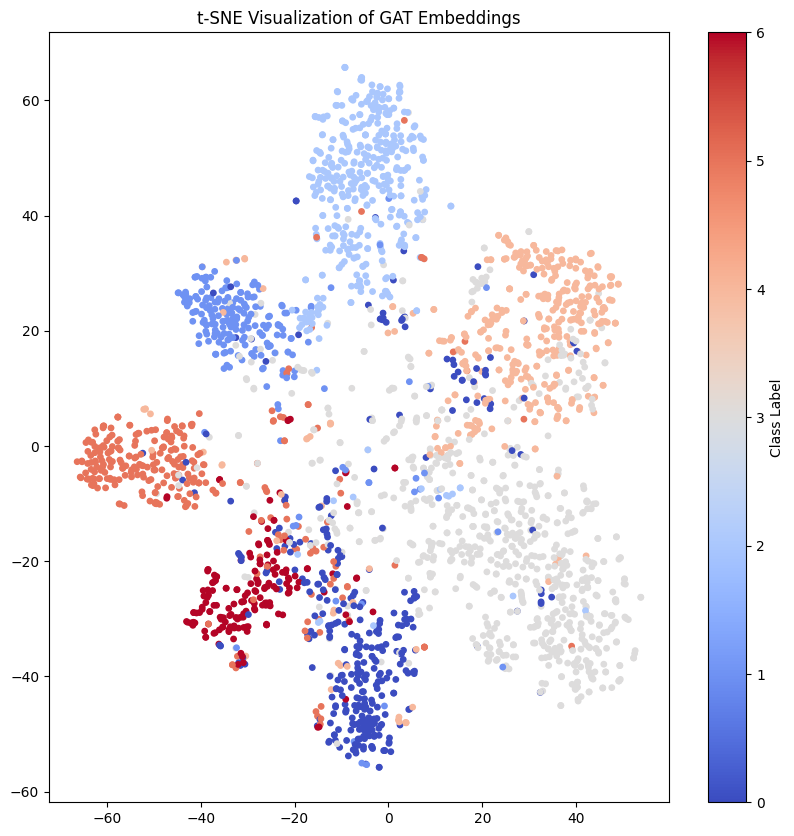

In [6]:
from sklearn.manifold import TSNE

# 모델의 첫 번째 계층 출력 (임베딩) 가져오기
gat.eval()
with torch.no_grad():
    embeddings = gat.layer1(data.x, data.edge_index).detach().cpu().numpy()

# t-SNE를 사용하여 2D로 축소
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# 시각화
plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=node_color, cmap='coolwarm', s=15)
plt.colorbar(scatter, label="Class Label")
plt.title("t-SNE Visualization of GAT Embeddings")
plt.show()


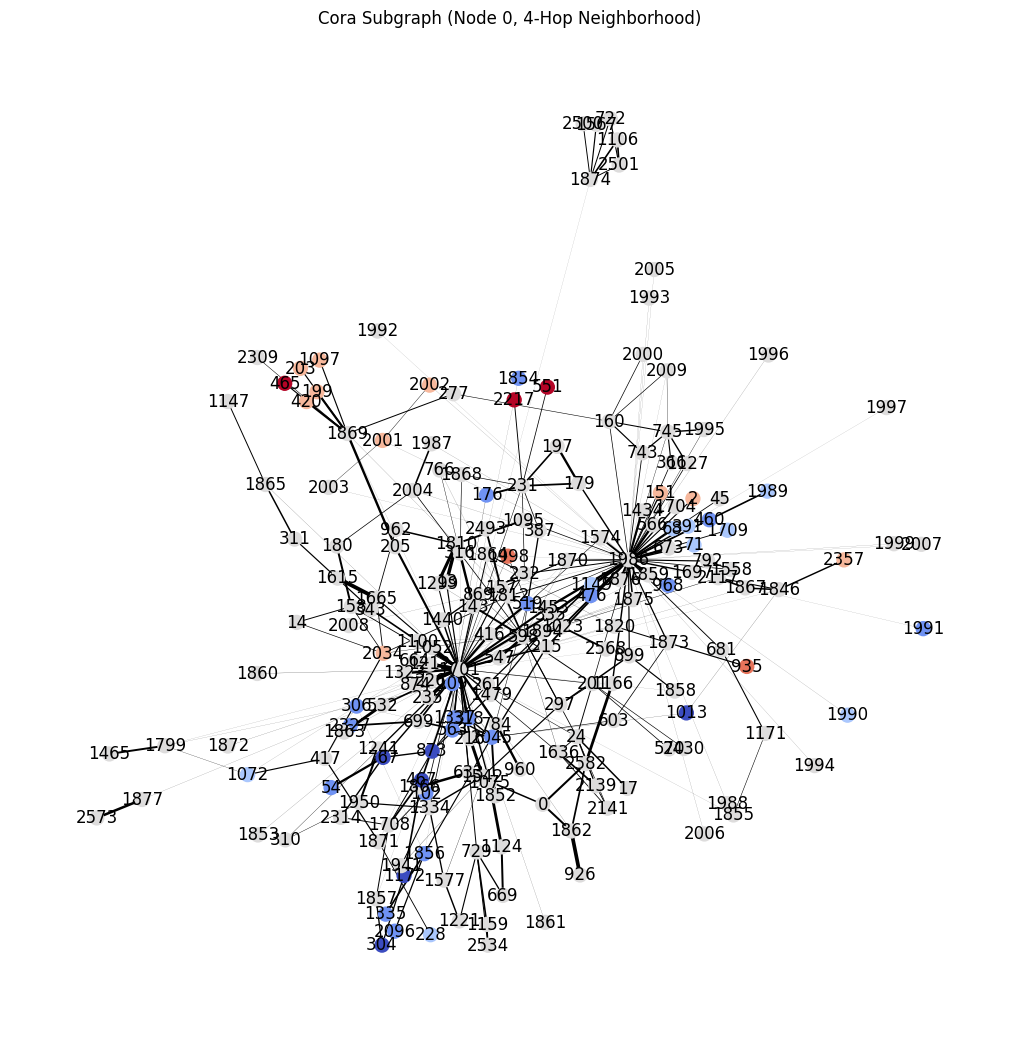

In [18]:
# 0번 노드의 반경 4-hop 이내 서브그래프 생성
subgraph_nodes = list(nx.ego_graph(graph, n=0, radius=4).nodes)  # 반경 4-hop
subgraph = graph.subgraph(subgraph_nodes).copy()  # 서브그래프 생성

# 어텐션 가중치를 서브그래프에 추가
for idx, (src, dst) in enumerate(zip(row.tolist(), col.tolist())):
    # 서브그래프에 존재하는 엣지만 처리
    if subgraph.has_edge(src, dst):
        subgraph[src][dst]["weight"] = attention_scores[idx].item()

# 엣지 두께로 어텐션 가중치 반영
edge_weights = [subgraph[u][v]["weight"] if "weight" in subgraph[u][v] else 0 for u, v in subgraph.edges]

# 서브그래프 시각화
plt.figure(figsize=(10, 10))
nx.draw(
    subgraph,
    node_color=[node_color[node] for node in subgraph.nodes],  # 서브그래프의 노드 색상
    cmap="coolwarm",
    node_size=100,
    with_labels=True,  # 노드 번호 표시
    width=[5 * w for w in edge_weights],  # 어텐션 가중치 반영
)
plt.title("Cora Subgraph (Node 0, 4-Hop Neighborhood)")
plt.show()

